Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
!nvidia-smi

Wed Jul 20 18:23:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.59       Driver Version: 512.59       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 53%   44C    P8    22W / 216W |   1416MiB /  8192MiB |     21%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf
tf.test.is_gpu_available(
cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("data/Train")
data_dir_test = pathlib.Path('data/Test')

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training',
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  crop_to_aspect_ratio=True)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

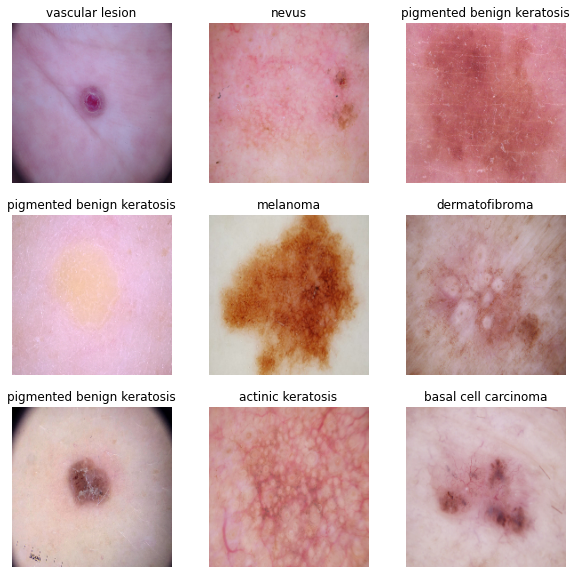

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for x in range(9):
    ax = plt.subplot(3, 3, x + 1)
    plt.imshow(images[x].numpy().astype("uint8"))
    plt.title(class_names[labels[x]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
### Your code goes here
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
num_class = 9
model = tf.keras.Sequential([
    layers.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    layers.Conv2D(16,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),    
    layers.Conv2D(32,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Conv2D(64,3,padding='same',activation= 'relu'),
    layers.MaxPooling2D(pool_size = 2, strides = 2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(num_class)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 19ms/step - loss: 1.9545 - accuracy: 0.2812 - val_loss: 1.6465 - val_accuracy: 0.4430
Epoch 2/20
56/56 [==============================] - 1s 10ms/step - loss: 1.5822 - accuracy: 0.4375 - val_loss: 1.6608 - val_accuracy: 0.4251
Epoch 3/20
56/56 [==============================] - 1s 10ms/step - loss: 1.4289 - accuracy: 0.5039 - val_loss: 1.4716 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 1s 10ms/step - loss: 1.3299 - accuracy: 0.5290 - val_loss: 1.4466 - val_accuracy: 0.4944
Epoch 5/20
56/56 [==============================] - 1s 10ms/step - loss: 1.2577 - accuracy: 0.5636 - val_loss: 1.3666 - val_accuracy: 0.5324
Epoch 6/20
56/56 [==============================] - 1s 10ms/step - loss: 1.1624 - accuracy: 0.5798 - val_loss: 1.4096 - val_accuracy: 0.4385
Epoch 7/20
56/56 [==============================] - 1s 10ms/step - loss: 1.0713 - accuracy: 0.6127 - val_loss: 1.3902 - val_accuracy: 0.5302
Epoch 8/20
56

### Visualizing training results

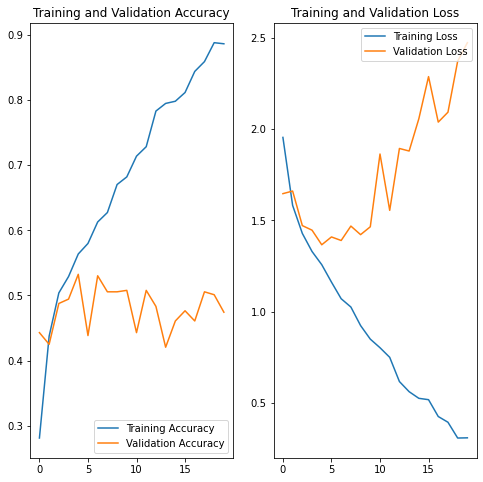

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

# Observations:
- Training accuracy is good but validation accuracy is low in comparison
- Drop out, Regularization, rebalance may help

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = Sequential([
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal_and_vertical", seed=123),
  layers.RandomRotation(1, seed=123),
  layers.RandomZoom(0.2, seed=123)
])

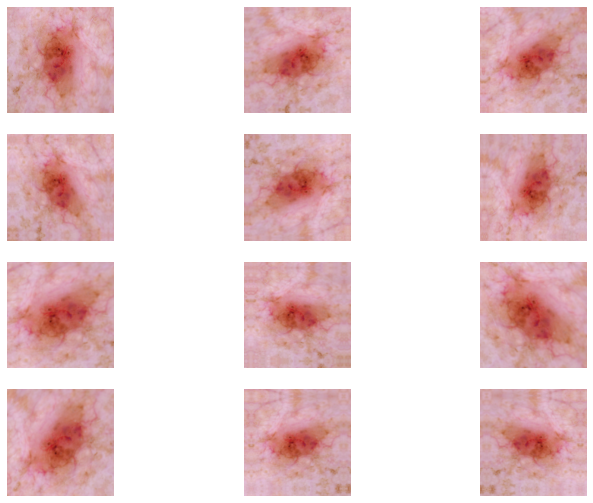

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
_, axs = plt.subplots(4,3,figsize=(12, 9))
axs = axs.flatten()
images, labels = next(iter(train_ds))
#plot orginalimage
axs[0].imshow(images[0]/255.)
axs[0].axis("off")
#plot augmented images
for ax in axs[1:]:
  augmented_images = data_augmentation(images)
  ax.imshow(augmented_images[0])
  ax.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
num_classes = 9
model = Sequential([
  layers.Rescaling(1./255, offset=0.0),
  data_augmentation,
    
  layers.Conv2D(32, (3,3), input_shape=(180,180,3), padding='same', activation='relu'),
  layers.Conv2D(32, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.7),
    
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.7),

  layers.Conv2D(128, (3,3), padding='same', activation='relu'),
  layers.Conv2D(128, (3,3), activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.7),
    
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(num_classes,activation='softmax')
])

### Compiling the model

In [23]:
## Your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              #loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
batch_size = 32
with tf.device("/gpu:0"):
    history = model.fit(train_ds, batch_size=batch_size,
                    validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 5s 47ms/step - loss: 2.0535 - accuracy: 0.1886 - val_loss: 2.0421 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 2s 39ms/step - loss: 2.0336 - accuracy: 0.1936 - val_loss: 2.0271 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 2s 39ms/step - loss: 2.0329 - accuracy: 0.1992 - val_loss: 2.0249 - val_accuracy: 0.1924
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 2.0336 - accuracy: 0.1975 - val_loss: 2.0218 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 2.0239 - accuracy: 0.1970 - val_loss: 2.0250 - val_accuracy: 0.1924
Epoch 6/20
56/56 [==============================] - 2s 40ms/step - loss: 2.0290 - accuracy: 0.1975 - val_loss: 2.0253 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 2s 39ms/step - loss: 2.0320 - accuracy: 0.1819 - val_loss: 2.0246 - val_accuracy: 0.2058
Epoch 8/20
56

### Visualizing the results

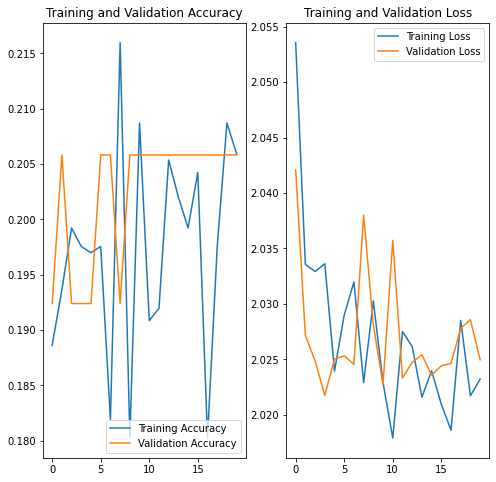

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

# Observations:
- Both training and validation scores are very low that indicates underfitting
- Parameter tuning will help a lot

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

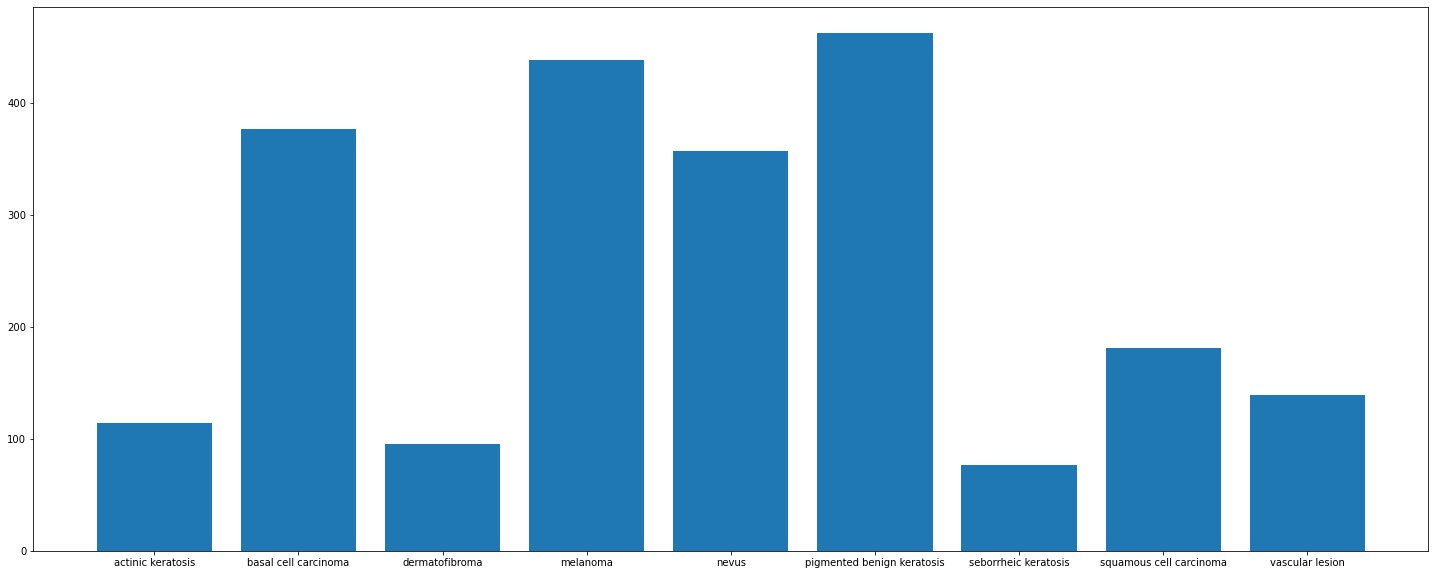

In [40]:
## Your code goes here.
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

#### - Which class has the least number of samples? 
- seborrheic keratosis 

#### - Which classes dominate the data in terms proportionate number of samples? 
- pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
import pathlib
from pathlib import Path
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    new_path=str(Path(path_to_training_dataset))+ "/" + i
    print(new_path)
    p = Augmentor.Pipeline(new_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

data\Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to data\Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2383010CFA0>: 100%|█| 500/500 [00:00<00:00, 574.71 Samples


data\Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to data\Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x238300C13D0>: 100%|█| 500/500 [00:00<00:00, 583.43 Samples


data\Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to data\Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2383010AFA0>: 100%|█| 500/500 [00:00<00:00, 561.17 Samples


data\Train/melanoma
Initialised with 438 image(s) found.
Output directory set to data\Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x238302CE8E0>: 100%|█| 500/500 [00:04<00:00, 121.15 Sample


data\Train/nevus
Initialised with 357 image(s) found.
Output directory set to data\Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x2383012E370>: 100%|█| 500/500 [00:03<00


data\Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to data\Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x23830317220>: 100%|█| 500/500 [00:00<00:00, 566.89 Samples


data\Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to data\Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x236F1EC8640>: 100%|█| 500/500 [00:02<00:00, 247.53 Sample


data\Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to data\Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x238302B2640>: 100%|█| 500/500 [00:00<00:


data\Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to data\Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x238302AF280>: 100%|█| 500/500 [00:00<00:


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
for i in class_names:
    directory =str(Path(data_dir_train))+"/"+i+'/'
    directory_out =str(Path(data_dir_train))+"/"+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [45]:
model = Sequential([
    layers.Rescaling(1./255, offset=0.0),
    
    layers.Conv2D(32, (3,3), input_shape=(180,180,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.Dropout(0.1),

    layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Dropout(0.1),

    layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Dropout(0.1),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes,activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [49]:
input_shape = (32, 180, 180, 3)
model.build(input_shape)

In [50]:
## your code goes here
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (32, 180, 180, 3)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (32, 180, 180, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (32, 180, 180, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (32, 90, 90, 32)          0         
_________________________________________________________________
batch_normalization_9 (Batch (32, 90, 90, 32)          128       
_________________________________________________________________
conv2d_22 (Conv2D)           (32, 88, 88, 32)          9248      
_________________________________________________________________
dropout_12 (Dropout)         (32, 88, 88, 32)         

#### **Todo:**  Train your model

In [51]:
epochs = 50
## Your code goes here, use 50 epochs.
batch_size = 32
with tf.device("/gpu:0"):
    history = model.fit(train_ds, batch_size=batch_size,
                    validation_data=val_ds, epochs=epochs)

Epoch 1/50
169/169 [==============================] - 8s 41ms/step - loss: 3.0047 - accuracy: 0.2637 - val_loss: 2.4717 - val_accuracy: 0.1403
Epoch 2/50
169/169 [==============================] - 7s 41ms/step - loss: 1.5735 - accuracy: 0.4052 - val_loss: 2.1287 - val_accuracy: 0.1581
Epoch 3/50
169/169 [==============================] - 7s 41ms/step - loss: 1.3786 - accuracy: 0.4664 - val_loss: 1.8361 - val_accuracy: 0.3437
Epoch 4/50
169/169 [==============================] - 7s 41ms/step - loss: 1.2768 - accuracy: 0.5224 - val_loss: 1.3604 - val_accuracy: 0.5115
Epoch 5/50
169/169 [==============================] - 7s 41ms/step - loss: 1.1232 - accuracy: 0.5701 - val_loss: 1.2542 - val_accuracy: 0.5486
Epoch 6/50
169/169 [==============================] - 7s 41ms/step - loss: 0.9716 - accuracy: 0.6328 - val_loss: 1.1020 - val_accuracy: 0.5954
Epoch 7/50
169/169 [==============================] - 7s 41ms/step - loss: 0.8550 - accuracy: 0.6790 - val_loss: 1.6917 - val_accuracy: 0.3690

#### **Todo:**  Visualize the model results

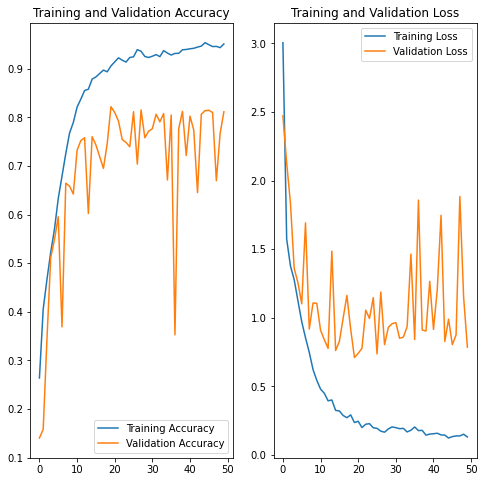

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



# Observation:
- Validation accuracy is wavering, can be rectified using parameter tuning.
- 95% training accuracy and 81% validation accuracy seems a good fit
- Rebalance of class has helped a lot.